# Carry Strategy
### Riya Sheth

riyasheth@uchicago.edu

### Imports

In [196]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import statistics
import statsmodels.api as sm
import warnings
from datetime import timedelta
from sklearn import preprocessing
from datetime import datetime
quandl.ApiConfig.api_key= "dSEK8-iUMxdiDUyrcPdc"
import random
import patchworklib as pw
from plotnine import *
warnings.filterwarnings('ignore')

### Introduction: Mechanisms of the Carry Strategy
An FX carry strategy borrows in a (low-interest-rate) currency and lends in
another currency (with high interest rates). This is typically arranged via a
cross-currency swap. The goal is to earn the interest rate differential between the two currencies, known as the "carry."

#### Carry Factor
The expected return from holding an asset assuming nothing changes but only time elapses.

### Description of Data

ISSC: Overnight Index Swaps- Spot Curve

ISSS: Overnight Index Swaps - Short Spot End

FX: The exchange rate between two currencies, here we have it against the USD as a base currency

In [63]:
start_date= pd.Timestamp('2014-12-03')
gbr_issc_data = quandl.get("YC/GBR_ISSC", start_date= '2014-12-03')/100 
gbr_isss_data = quandl.get("YC/GBR_ISSS", start_date='2014-12-03')/100 
fx_g = quandl.get('CUR/GBP', start_date= '2014-12-03', 
                      end_date='2023-02-10', returns="pandas",
                     api_key="dSEK8-iUMxdiDUyrcPdc")
fx_g = fx_g.interpolate(axis = 0, method = 'index').resample('W-WED').fillna(method="ffill")

In [64]:
frames=[gbr_issc_data, gbr_isss_data]
gbr_data = pd.concat(frames)
gbr_data.drop_duplicates(inplace=True)
gbr_data = gbr_data.interpolate(axis = 0, method = 'index').resample('W-WED').fillna(method="ffill")
end_date= gbr_data.index[-1]

### Obtaining Yield Curves and FX Rates

In [99]:
def bond_price(zcb, coupon_rate, tenor):
    times = np.arange(tenor, 0, step=-0.25)[::-1]
    if times.shape[0]==0:
        p = 1.0
    else:
        r = np.interp(times, zcb.index.values, zcb.values) # Linear interpolation
        p = np.exp(-tenor*r[-1]) + 0.25 * coupon_rate * np.exp(-r*times).sum()
    return p

def compute_zcb_curve(spot_rates_curve):
    zcb_rates = spot_rates_curve.copy()
    for curve in spot_rates_curve.columns:
        spot = spot_rates_curve[curve]
        for tenor, spot_rate in spot.iteritems():
            if tenor>0.001:
                times = np.arange(tenor-0.25, 0, step=-0.25)[::-1]
                coupon_half_yr = 0.25*spot_rate
                z = np.interp(times, zcb_rates[curve].index.values, zcb_rates[curve].values) # Linear interpolation
                preceding_coupons_val = (coupon_half_yr*np.exp(-z*times)).sum()
                zcb_rates[curve][tenor] = -np.log((1-preceding_coupons_val)/(1+coupon_half_yr))/tenor
    return zcb_rates

In [66]:
def obtain_data(country, start_date, end_date):
    
    country_codes = {
    'Thailand': ('THB', 'THA', [1/12, 3/12, 6/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15]),
    'Vietnam': ('VND', 'VNM', [1, 2, 3, 5, 7, 10, 15]),
    'Pakistan': ('PKR', 'PAK', [3/12, 6/12, 1, 3, 5, 10]),
    'Philippines': ('PHP', 'PHL', [1/12, 3/12, 6/12, 1, 2, 3, 4, 5, 7, 10, 20, 25])}

    fx_code, cur_code, columns = country_codes[country]
    cur_symbol = 'YC/{}'.format(cur_code)
    quandl.ApiConfig.api_key = 'dSEK8-iUMxdiDUyrcPdc'
    
    #getting yield curve
    bond_yield = quandl.get(cur_symbol,  start_date= start_date, end_date= end_date)
    bond_yield.columns = columns
    
    
    #getting exchange rate data
    fx_symbol = "CUR/{}".format(fx_code)
    fx = quandl.get(fx_symbol, start_date= start_date, end_date= end_date)
    
    fx = fx.interpolate(axis = 0, method = 'index').resample('W-WED').fillna(method="ffill")
    bond_yield = bond_yield.interpolate(axis = 0, method = 'index').resample('W-WED').fillna(method="ffill")/100
    
    #obtain the zero coupon bond
    zero_coupon_bond = compute_zcb_curve(bond_yield.T)

    return bond_yield, zero_coupon_bond, fx

In [67]:
bond_yield_t, zero_coupon_bond_t, fx_t= obtain_data("Thailand", start_date, end_date)
bond_yield_v, zero_coupon_bond_v, fx_v= obtain_data("Vietnam", start_date, end_date)
bond_yield_p, zero_coupon_bond_p, fx_p= obtain_data("Pakistan", start_date, end_date)
bond_yield_ph, zero_coupon_bond_ph, fx_ph= obtain_data("Philippines", start_date, end_date)

In [68]:
def graph_term_rates(rate, country):
    columns= rate.columns
    low=[]
    high=[]
    for c in columns:
        low.append(rate[c].min())
        high.append(rate[c].max())
    data1= {'rates': low, 'tenure': columns, 'legend': ['low']*len(columns)}
    data2= {'rates': high, 'tenure': columns, 'legend': ['high']*len(columns)}
    df1 = pd.DataFrame(data1)
    df2 = pd.DataFrame(data2)
    df = pd.concat([df1, df2])
    plot= (ggplot(df)
    + aes(y='rates', x='tenure', color='legend')
    + geom_line()
    + labs(title= country)
    )
    return plot

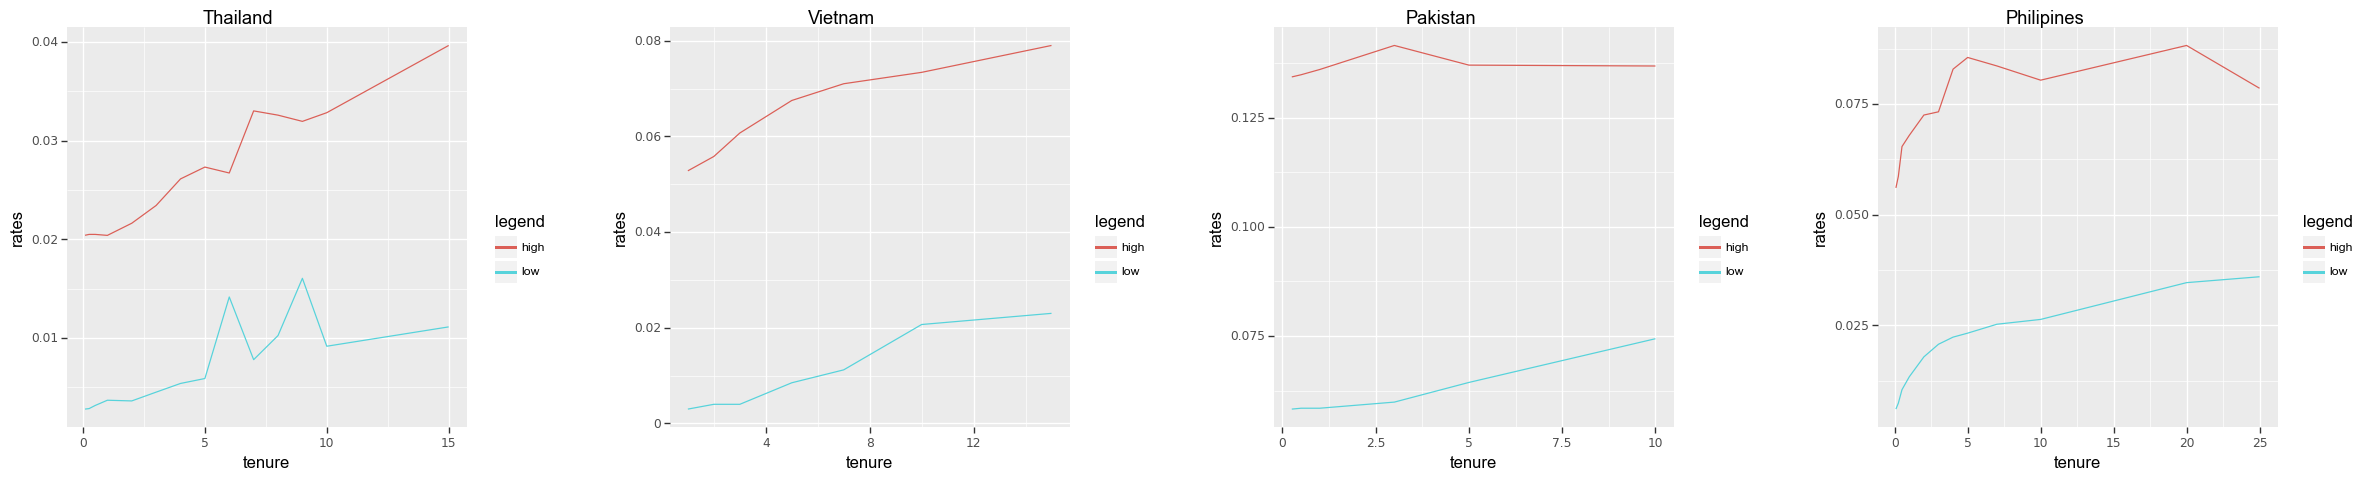

In [69]:
g1= graph_term_rates(bond_yield_t, 'Thailand')
g2= graph_term_rates(bond_yield_v, 'Vietnam')
g3= graph_term_rates(bond_yield_p, 'Pakistan')
g4= graph_term_rates(bond_yield_ph, 'Philipines')
g1 = pw.load_ggplot(g1, figsize=(4, 4))
g2 = pw.load_ggplot(g2, figsize=(4, 4))
g3 = pw.load_ggplot(g3, figsize=(4, 4))
g4 = pw.load_ggplot(g4, figsize=(4, 4))

g1234 = (g1|g2|g3|g4)
g1234.savefig()

The yield curve is a graph that plots the yield (interest rate) of a security as a function of its time to maturity

All the graphs follow the trend of higher tenure, higher interest rates as expected

We see a few hiccups in the graph of Thailand. The spikes could be for the following reasons:
1. Supply and demand imbalances
2. Monetary policy changes
3. Political events
4. Economic data releases

### Obtaining Bond Prices

In [90]:
def return_bond_prices(df, df2):
    
    price1=[]
    price2=[]
    
    for i in df.index:
        price1.append(bond_price(df2.loc[i], df.loc[i][5], 5))
        price2.append(bond_price(df2.loc[i], df.loc[i][5], 5-1/52))
    
    date= df2.index
    bond_prices_df= pd.DataFrame(index= date)
    bond_prices_df['Price 5Y']= price1
    bond_prices_df['Price 4.98Y']= price2
    
    return bond_prices_df

In [91]:
bond_prices_t= return_bond_prices(bond_yield_t, zero_coupon_bond_t.T)
bond_prices_v= return_bond_prices(bond_yield_v, zero_coupon_bond_v.T)
bond_prices_p= return_bond_prices(bond_yield_p, zero_coupon_bond_p.T)
bond_prices_ph= return_bond_prices(bond_yield_ph, zero_coupon_bond_ph.T)

In [110]:
def create_strategy_dataframe(bond_prices, fx_g, fx_other, gbr_data, bond_yield):
    
    latest_start_date = min(bond_prices.index[0], fx_g.index[0], fx_other.index[0], gbr_data.index[0])
    earliest_end_date= min(bond_prices.index[-1], fx_g.index[-1], fx_other.index[-1], gbr_data.index[-1])
   
    mask = (bond_prices.index >= latest_start_date) & (bond_prices.index <= earliest_end_date)
    mask2 = (fx_g.index >= latest_start_date) & (fx_g.index <= earliest_end_date)
    mask3 = (fx_other.index >= latest_start_date) & (fx_other.index <= earliest_end_date)
    mask4 = (gbr_data.index >= latest_start_date) & (gbr_data.index <= earliest_end_date)
    
    bond_prices_new= bond_prices[mask]
    fx_g_new= fx_g[mask2]
    fx_other_new= fx_other[mask3]
    gbr_data_new= gbr_data[mask4]
    
    fx3= fx_g_new['RATE']/fx_other_new['RATE']
    spread=  (bond_yield[5]) - (gbr_data_new['5.0Y'])
    
    strategy_dataframe= bond_prices_new
    strategy_dataframe['FX-Rate-GBP']= fx_g_new
    strategy_dataframe['FX-Rate-Lending']= fx_other_new
    strategy_dataframe['FX-Rate']= fx3
    strategy_dataframe['GBR-5Y'] = list(gbr_data_new['5.0Y'])
    strategy_dataframe['SR-5Y']= list(bond_yield[5])
    strategy_dataframe['5Y Spread']= spread
    strategy_dataframe['Borrowing_Rate']= 0.005+ gbr_data_new['0.08Y']
    return strategy_dataframe


In [112]:
strategy_dataframe_t= create_strategy_dataframe(bond_prices_t, fx_g, fx_t, gbr_data, bond_yield_t)
strategy_dataframe_v= create_strategy_dataframe(bond_prices_v, fx_g, fx_v, gbr_data, bond_yield_v)
strategy_dataframe_ph= create_strategy_dataframe(bond_prices_ph, fx_g, fx_t, gbr_data, bond_yield_ph)
strategy_dataframe_p= create_strategy_dataframe(bond_prices_p, fx_g, fx_p, gbr_data, bond_yield_p)

### An example of the strategy dataframe
To execute the strategy only the following columns are required

In [192]:
strategy_dataframe_v.head()

,Price 5Y,Price 4.98Y,FX-Rate-GBP,FX-Rate-Lending,FX-Rate,GBR-5Y,SR-5Y,5Y Spread,Borrowing_Rate
Date,,,,,,,,,
2014-12-03,0.999890,1.001377,0.637756,21365.166667,0.00003,0.012731,0.05988,0.047149,0.009275
2014-12-10,0.999898,1.001380,0.636345,21349.600000,0.00003,0.012382,0.06012,0.047738,0.009262
2014-12-17,0.999900,1.001396,0.642142,21382.866667,0.00003,0.011154,0.06188,0.050726,0.009253
2014-12-24,0.999880,1.001440,0.642895,21394.633333,0.00003,0.012158,0.06350,0.051342,0.009277
2014-12-31,0.999880,1.001427,0.641866,21394.800000,0.00003,0.011214,0.06250,0.051286,0.009281


### Assumptions for the Strategy:


#### 1. Weekly Trading: We trade only on a Wednesday. 
This could also have additional benefits such as:

a. Volatility: Foreign exchange markets are known for their volatility, and sudden changes in exchange rates can lead to large losses in an FX carry strategy. By trading on a weekly basis, a trader can reduce the impact of short-term volatility and minimize the risk of losses from sudden changes in exchange rates.

b. Interest rate changes: Interest rates can change quickly and unexpectedly, and these changes can impact the performance of an FX carry strategy. By trading on a weekly basis, a trader can stay ahead of these changes and adjust the trade accordingly.

c. Time decay: By trading on a weekly basis, a trader can reduce the impact of time decay and potentially increase the overall returns of the strategy.


#### 2. We can only buy bonds with 5Y tenure

In [374]:
def FXCarry_Individual_Currencies(df):
    
    fx_data= pd.DataFrame()
    pnl_list=[]
    basis_points= 50*0.0001
    date=[]
    initial_gbp_list=[]
    notional_list=[]
    new_gbp_list=[]
    bond_price_list=[]
    
    for i in range(len(df)-1):
    
        if df['SR-5Y'][i]< basis_points+  df['GBR-5Y'][i]:
            continue
        else:
            initial_capital= 2000000 #in USD
            borrowed_capital = 8000000 #in USD
            
            true_initial_capital= initial_capital * df['FX-Rate-GBP'][i] #in GBP
            true_borrowed_capital= borrowed_capital * df['FX-Rate-GBP'][i]
            total_gbp= true_initial_capital + true_borrowed_capital
            initial_gbp_list.append(total_gbp)
            
            annual_borrowing_rate= df['Borrowing_Rate'][i]
            weekly_borrowing_rate= (1+ annual_borrowing_rate)**(1/52)-1
            bond_price_list.append(df['Price 4.98Y'][i]/df['Price 5Y'][i])
            
            borrowing_cost= weekly_borrowing_rate*total_gbp #in GBP
            total_other= total_gbp/df['FX-Rate'][i] #in other currency
            notional= total_other/df['Price 5Y'][i] # in other currency
            notional_list.append(notional)
            
            #After 1 week
            
            new_other_currency= notional * df['Price 4.98Y'][i] #in other currency
            new_gbp= new_other_currency*df['FX-Rate'][i+1] # in GBP
            new_gbp_list.append(new_gbp)
    
            pnl_1= new_gbp-total_gbp #in GBP
            pnl= pnl_1-borrowing_cost #in GBP
            pnl_usd= pnl/df['FX-Rate-GBP'][i]
            pnl_list.append(pnl_usd)
            date.append(df.index[i])
            
    fx_data.index= date
    fx_data['Initial GBP Amount']= initial_gbp_list
    fx_data['Final GBP Amount']= new_gbp_list
    fx_data['Bond Price Ratio']= bond_price_list
    fx_data['Notional']= notional_list
    fx_data['PnL']= pnl_list
    fx_data['Cum PnL']= fx_data['PnL'].cumsum()
    fx_data['Returns']= fx_data['PnL']/2000000
    fx_data['Cum Returns']= fx_data['Returns'].cumsum()
    return fx_data

In [217]:
def graph_cum_pnl(pnl, date, country):
    
    
    
    

In [210]:
fx_data_t= FXCarry_Individual_Currencies(strategy_dataframe_t)
fx_data_v= FXCarry_Individual_Currencies(strategy_dataframe_v)
fx_data_p= FXCarry_Individual_Currencies(strategy_dataframe_p)
fx_data_ph= FXCarry_Individual_Currencies(strategy_dataframe_ph)

### The dataframes for the trades made with different strategies

In [213]:
fx_data_t.head()

,Initial GBP Amount,Final GBP Amount,Bond Price Ratio,Notional,PnL,Cum PnL,Returns,Cum Returns
2014-12-03,6377560.0,6.372108e+06,1.000539,3.285662e+08,-10324.643816,-10324.643816,-0.005162,-0.005162
2014-12-10,6363450.0,6.400622e+06,1.000538,3.282966e+08,56641.537739,46316.893923,0.028321,0.023158
2014-12-17,6421420.0,6.445478e+06,1.000487,3.295404e+08,35694.114956,82011.008879,0.017847,0.041006
2014-12-24,6428950.0,6.418954e+06,1.000458,3.288551e+08,-17325.008805,64686.000075,-0.008663,0.032343
2014-12-31,6418660.0,6.626742e+06,1.000447,3.289906e+08,322405.747130,387091.747205,0.161203,0.193546


In [214]:
fx_data_v.head()

,Initial GBP Amount,Final GBP Amount,Bond Price Ratio,Notional,PnL,Cum PnL,Returns,Cum Returns
2014-12-03,6377560.0,6.377561e+06,1.001487,2.136752e+11,-1773.855946,-1773.855946,-0.000887,-0.000887
2014-12-10,6363450.0,6.420930e+06,1.001482,2.135177e+11,88554.626173,86780.770227,0.044277,0.043390
2014-12-17,6421420.0,6.435028e+06,1.001496,2.138501e+11,19420.460244,106201.230471,0.009710,0.053101
2014-12-24,6428950.0,6.428625e+06,1.001560,2.139721e+11,-2281.786815,103919.443656,-0.001141,0.051960
2014-12-31,6418660.0,6.619668e+06,1.001547,2.139737e+11,311384.840731,415304.284387,0.155692,0.207652


In [215]:
fx_data_p.head()

,Initial GBP Amount,Final GBP Amount,Bond Price Ratio,Notional,PnL,Cum PnL,Returns,Cum Returns
2014-12-03,6377560.0,6.437346e+06,1.002228,1.016836e+09,91968.422570,91968.422570,0.045984,0.045984
2014-12-10,6363450.0,6.442382e+06,1.002188,1.007376e+09,122265.789027,214234.211597,0.061133,0.107117
2014-12-17,6421420.0,6.446196e+06,1.002188,1.006295e+09,36812.133053,251046.344650,0.018406,0.125523
2014-12-24,6428950.0,6.426437e+06,1.002188,1.005798e+09,-5685.553902,245360.790748,-0.002843,0.122680
2014-12-31,6418660.0,6.621880e+06,1.002188,1.006779e+09,314831.197932,560191.988679,0.157416,0.280096


In [216]:
fx_data_ph.head()

,Initial GBP Amount,Final GBP Amount,Bond Price Ratio,Notional,PnL,Cum PnL,Returns,Cum Returns
2014-12-03,6377560.0,6.372885e+06,1.000661,3.285685e+08,-9106.359147,-9106.359147,-0.004553,-0.004553
2014-12-10,6363450.0,6.402165e+06,1.000780,3.282992e+08,59065.835637,49959.476491,0.029533,0.024980
2014-12-17,6421420.0,6.447087e+06,1.000737,3.295429e+08,38198.987367,88158.463858,0.019099,0.044079
2014-12-24,6428950.0,6.419675e+06,1.000570,3.288571e+08,-16203.364007,71955.099851,-0.008102,0.035978
2014-12-31,6418660.0,6.627558e+06,1.000570,3.289927e+08,323677.477106,395632.576957,0.161839,0.197816


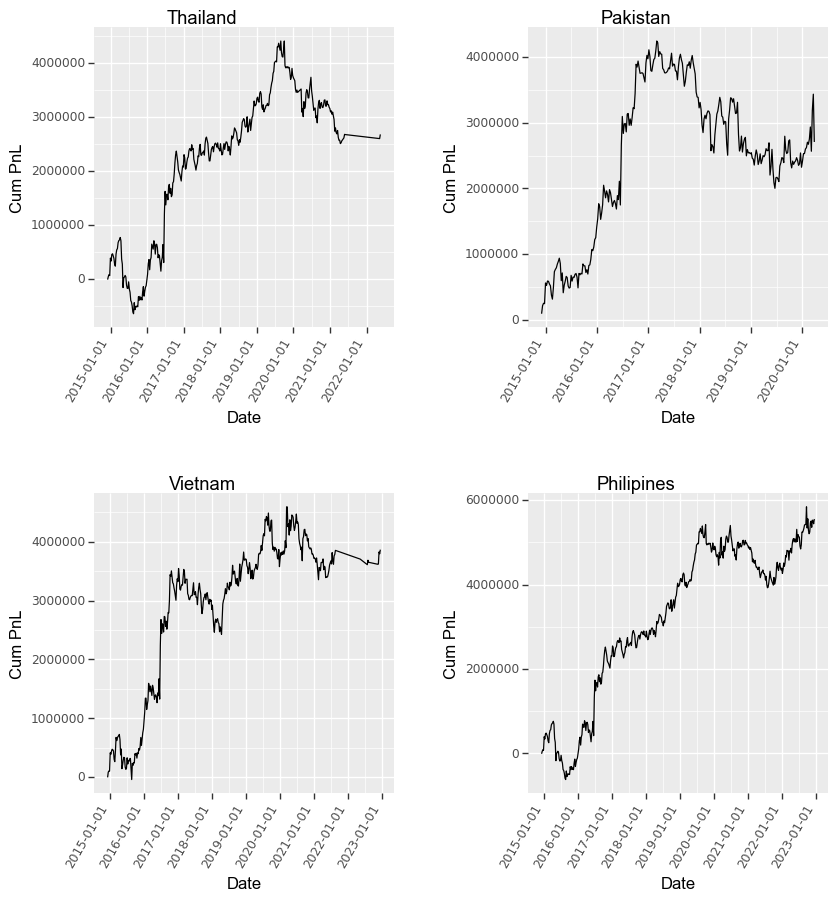

In [218]:
g1= graph_cum_pnl(list(fx_data_t['Cum PnL']), list(fx_data_t.index), 'Thailand')
g2= graph_cum_pnl(list(fx_data_v['Cum PnL']), list(fx_data_v.index), 'Vietnam')
g3= graph_cum_pnl(list(fx_data_p['Cum PnL']), list(fx_data_p.index), 'Pakistan')
g4= graph_cum_pnl(list(fx_data_ph['Cum PnL']), list(fx_data_ph.index),'Philipines')

g1 = pw.load_ggplot(g1, figsize=(3, 3))
g2 = pw.load_ggplot(g2, figsize=(3, 3))
g3 = pw.load_ggplot(g3, figsize=(3, 3))
g4 = pw.load_ggplot(g4, figsize=(3, 3))

g1234 = (g1/g2|g3/g4)
g1234.savefig()

### Analysis:
All the currencies follow a similar trend which increase in PnL with a dip in end of 2021 and beginning of 2022.

The reason for the dip could be:
1. Rising inflation expectations: The end of 2021 and beginning of 2022 saw rising inflation expectations, which led to an increase in bond yields and a tightening of monetary policy. This led to an increase in short-term interest rates, which had a negative impact on the FX carry trade.
2. Rising interest rates: One of the main drivers of the FX carry trade is the difference in interest rates between two currencies. If the interest rate differential between two currencies narrows, or if interest rates rise, it can lead to losses in the FX carry trade. In the end of 2021 and beginning of 2022, many central banks around the world started to raise interest rates, which led to a narrowing of interest rate differentials and losses in the FX carry trade.
3. Geopolitical events: Geopolitical events, such as changes in government or trade tensions, can also impact the FX carry trade. The end of 2021 and beginning of 2022 saw a number of geopolitical events that led to increased market uncertainty and losses in the FX carry trade.


The reason that all EM currencies have a very similar:
1. Correlation: Emerging market currencies are often highly correlated with each other, meaning that they tend to move in a similar direction. This can result in similar P&L outcomes for an FX trade strategy that involves multiple emerging market currencies. This correlation is depcited in the next few cells.
2. Market conditions: Emerging market currencies can be affected by similar macroeconomic conditions, such as changes in global interest rates, commodity prices, or geopolitical events. This can result in similar P&L outcomes for an FX trade strategy that involves multiple emerging market currencies.
3. Currency composition: Emerging market currencies can have a similar composition, with many of them being heavily reliant on commodities or being sensitive to changes in the global economy. This can result in similar P&L outcomes for an FX trade strategy that involves multiple emerging market currencies.
4. Market size: Emerging market currencies can have smaller and less liquid markets compared to developed market currencies. This can result in similar P&L outcomes for an FX trade strategy that involves multiple emerging market currencies, as it can be difficult to execute large trades without significantly impacting market prices.

In [236]:
def calculate_statistics_from_pnl(returns):
    annualized_return = (1 + returns).prod()**(252/len(returns)) - 1
    mean_return = returns.mean()
    volatility = returns.std()
    risk_free_rate = 0.02 #arbitary risk free rate
    sharpe_ratio = (mean_return - risk_free_rate) / volatility
    cumulative_returns = (1 + returns).cumprod()
    running_max = np.maximum.accumulate(cumulative_returns)
    drawdown = cumulative_returns / running_max - 1
    maximum_drawdown = drawdown.min()
    return [annualized_return, mean_return, volatility, sharpe_ratio, maximum_drawdown]

In [237]:
stat_t= calculate_statistics_from_pnl(fx_data_t['Returns'])
stat_p= calculate_statistics_from_pnl(fx_data_p['Returns'])
stat_v= calculate_statistics_from_pnl(fx_data_v['Returns'])
stat_ph= calculate_statistics_from_pnl(fx_data_ph['Returns'])

In [247]:
columns= ['Annualized Return', 'Mean Return', 'Volatility', 'Sharpe Ratio', 'Maximum Drawdown']
stat= pd.DataFrame(columns= columns)
stat_t = pd.Series(stat_t, index=columns)
stat_p = pd.Series(stat_p, index=columns)
stat_v = pd.Series(stat_v, index=columns)
stat_ph = pd.Series(stat_ph, index=columns)
stat= stat.append(stat_t, ignore_index=True)
stat= stat.append(stat_p, ignore_index=True)
stat= stat.append(stat_v, ignore_index=True)
stat= stat.append(stat_ph, ignore_index=True)
stat.index= ['Thailand', 'Pakistan', 'Vietnam', 'Philipines']
stat

,Annualized Return,Mean Return,Volatility,Sharpe Ratio,Maximum Drawdown
Thailand,0.633033,0.003993,0.064559,-0.247943,-0.672602
Pakistan,0.407511,0.004868,0.083611,-0.180977,-0.777941
Vietnam,1.206803,0.005368,0.068143,-0.214732,-0.540161
Philipines,2.005332,0.006609,0.067286,-0.199018,-0.615395


### Analysis of statistics
#### Why did Philipines do the best?

The Philippines has a lot of things going for it that make it a great destination for foreign exchange (FX) carry trade strategies. Firstly, the country has maintained high interest rates, which is music to the ears of investors. This means that they can borrow money in a currency that has a lower interest rate, and then invest it in the Philippines where they can earn a higher return on their investment.

Another factor that makes the Philippines a great choice is its strong macroeconomic fundamentals. The economy has been growing steadily, inflation is low, and the country has a favorable balance of payments position. All of this stability has given investors confidence in the country, reducing the risk of any major currency fluctuations.

Finally, the Philippines has a favorable political climate, with a stable government and business-friendly policies. This has attracted foreign investment and helped to support the country's economy, making it a great destination for FX carry trade strategies.


#### What does a negative sharpe ratio say?
In general, a negative Sharpe ratio suggests that an investment is not providing a sufficient return to compensate for the risk taken, and that investors may be better off investing in a lower-risk alternative, such as a U.S. Treasury bond.
Hence this demonstrates that the trade is very risky and there is a need for better risk-management


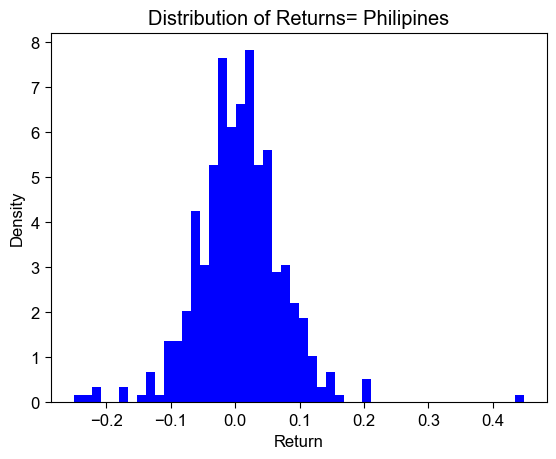

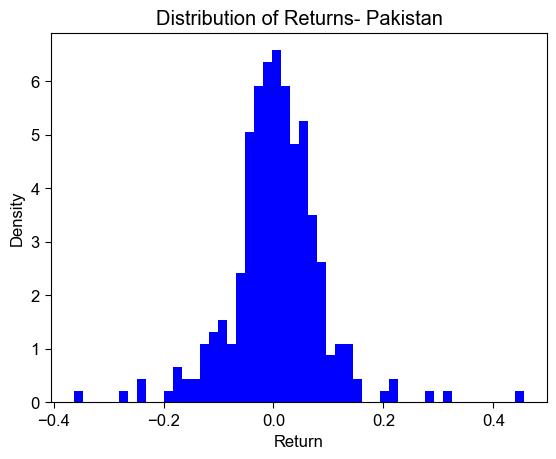

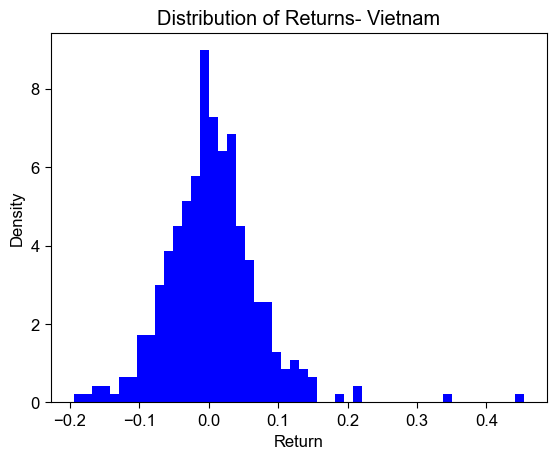

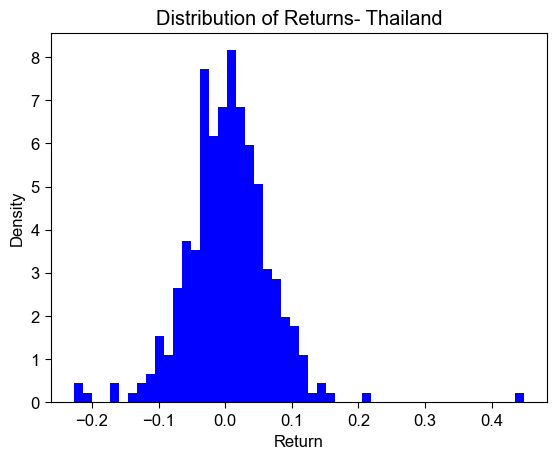

In [447]:
plt.hist(fx_data_ph['Returns'], bins=50, density=True, color='blue')
plt.xlabel('Return')
plt.ylabel('Density')
plt.title('Distribution of Returns= Philipines')
plt.show()
plt.hist(fx_data_p['Returns'], bins=50, density=True, color='blue')
plt.xlabel('Return')
plt.ylabel('Density')
plt.title('Distribution of Returns- Pakistan')
plt.show()
plt.hist(fx_data_v['Returns'], bins=50, density=True, color='blue')
plt.xlabel('Return')
plt.ylabel('Density')
plt.title('Distribution of Returns- Vietnam')
plt.show()
plt.hist(fx_data_t['Returns'], bins=50, density=True, color='blue')
plt.xlabel('Return')
plt.ylabel('Density')
plt.title('Distribution of Returns- Thailand')
plt.show()

Here we can see according to the distribution of returns for all the EM currencies, the returns are nearing 0. This makes us consider if it is worth taking risks for this returns. From these graphs it does not look like there is great positive skew. 

In [252]:
def FXCarry_Al_Currencies(df, df_v, df_p, df_ph):
    fx_data= pd.DataFrame()
    pnl_list=[]
    basis_points= 50*0.0001
    date=[]
    
    for i in range(len(df_p)-1):
        
        pnl_t= -1000000000
        pnl_v= -1000000000
        pnl_p= -1000000000
        pnl_ph= -1000000000
        
    
        if df['SR-5Y'][i] < basis_points+  df['GBR-5Y'][i]:
            pass
        else:
            initial_capital= 2000000 #in USD
            borrowed_capital = 8000000 #in USD
            true_initial_capital= initial_capital * df['FX-Rate-GBP'][i] #in GBP
            true_borrowed_capital= borrowed_capital * df['FX-Rate-GBP'][i]
            total_gbp= true_initial_capital + true_borrowed_capital
            annual_borrowing_rate= df['Borrowing_Rate'][i]
            weekly_borrowing_rate= (1+ annual_borrowing_rate)**(1/52)-1
            borrowing_cost= weekly_borrowing_rate*total_gbp #in GBP
            total_other= total_gbp/df['FX-Rate'][i] #in other currency
            notional= total_other/df['Price 5Y'][i] # in other currency
            new_other_currency= notional * df['Price 4.98Y'][i] #in other currency
            new_gbp= new_other_currency*df['FX-Rate'][i+1] # in GBP
            pnl_1= new_gbp-total_gbp #in GBP
            pnl_t= pnl_1-borrowing_cost #in GBP
            pnl_t= pnl_t/df['FX-Rate-GBP'][i]
        
        if df_v['SR-5Y'][i] < basis_points+  df_v['GBR-5Y'][i]:
            pass
        else:
            initial_capital= 2000000 #in USD
            borrowed_capital = 8000000 #in USD
            true_initial_capital= initial_capital * df_v['FX-Rate-GBP'][i] #in GBP
            true_borrowed_capital= borrowed_capital * df_v['FX-Rate-GBP'][i]
            total_gbp= true_initial_capital + true_borrowed_capital
            annual_borrowing_rate= df_v['Borrowing_Rate'][i]
            weekly_borrowing_rate= (1+ annual_borrowing_rate)**(1/52)-1
            borrowing_cost= weekly_borrowing_rate*total_gbp #in GBP
            total_other= total_gbp/df_v['FX-Rate'][i] #in other currency
            notional= total_other/df_v['Price 5Y'][i] # in other currency
            new_other_currency= notional * df_v['Price 4.98Y'][i] #in other currency
            new_gbp= new_other_currency*df_v['FX-Rate'][i+1] # in GBP
            pnl_1= new_gbp-total_gbp #in GBP
            pnl_v= pnl_1-borrowing_cost #in GBP
            pnl_v= pnl_v/df_v['FX-Rate-GBP'][i]
            
        if df_p['SR-5Y'][i] < basis_points+  df_p['GBR-5Y'][i]:
            pass
        else:
            initial_capital= 2000000 #in USD
            borrowed_capital = 8000000 #in USD
            true_initial_capital= initial_capital * df_p['FX-Rate-GBP'][i] #in GBP
            true_borrowed_capital= borrowed_capital * df_p['FX-Rate-GBP'][i]
            total_gbp= true_initial_capital + true_borrowed_capital
            annual_borrowing_rate= df_p['Borrowing_Rate'][i]
            weekly_borrowing_rate= (1+ annual_borrowing_rate)**(1/52)-1
            borrowing_cost= weekly_borrowing_rate*total_gbp #in GBP
            total_other= total_gbp/df_p['FX-Rate'][i] #in other currency
            notional= total_other/df_p['Price 5Y'][i] # in other currency
            new_other_currency= notional * df_p['Price 4.98Y'][i] #in other currency
            new_gbp= new_other_currency*df_p['FX-Rate'][i+1] # in GBP
            pnl_1= new_gbp-total_gbp #in GBP
            pnl_p= pnl_1-borrowing_cost #in GBP
            pnl_p= pnl_p/df_p['FX-Rate-GBP'][i]
            
            
        if df_ph['SR-5Y'][i] < basis_points+  df_ph['GBR-5Y'][i]:
            pass
        else:
            initial_capital= 2000000 #in USD
            borrowed_capital = 8000000 #in USD
            true_initial_capital= initial_capital * df_ph['FX-Rate-GBP'][i] #in GBP
            true_borrowed_capital= borrowed_capital * df_ph['FX-Rate-GBP'][i]
            total_gbp= true_initial_capital + true_borrowed_capital
            annual_borrowing_rate= df_ph['Borrowing_Rate'][i]
            weekly_borrowing_rate= (1+ annual_borrowing_rate)**(1/52)-1
            borrowing_cost= weekly_borrowing_rate*total_gbp #in GBP
            total_other= total_gbp/df_ph['FX-Rate'][i] #in other currency
            notional= total_other/df_ph['Price 5Y'][i] # in other currency
            new_other_currency= notional * df_ph['Price 4.98Y'][i] #in other currency
            new_gbp= new_other_currency*df_ph['FX-Rate'][i+1] # in GBP
            pnl_1= new_gbp-total_gbp #in GBP
            pnl_ph= pnl_1-borrowing_cost #in GBP
            pnl_ph= pnl_ph/df_ph['FX-Rate-GBP'][i]
            
        if pnl_t== -1000000 and pnl_v== -1000000 and pnl_p== -1000000 and pnl_ph== -1000000:
            continue
        
        else:
            pnl_usd= max([pnl_t, pnl_p, pnl_v, pnl_ph])
            pnl_list.append(pnl_usd)
            date.append(df.index[i])
            
    fx_data.index= date
    fx_data['PnL']= pnl_list
    fx_data['Cum PnL']= fx_data['PnL'].cumsum()
    fx_data['Returns']= fx_data['PnL']/2000000
    fx_data['Cum Returns']= fx_data['Returns'].cumsum()
    return fx_data

#### Look ahead bias
The above strategy was used were we assume we can trade all currencies. However, this just a hypothetical case of the best scenario in trading. 

#### This was justed used as a benchmark for comparison and analysis and in no way is remotely possible in the real world. 

Look Ahead Bias:
n the context of foreign exchange (FX) carry trade strategies, a look-ahead bias can occur if the interest rate differentials or exchange rates used in the calculation of returns are based on future data that was not available at the time the trade was executed. For example, if an investor uses future interest rate differentials to calculate returns for an FX carry trade strategy, the actual returns may differ from the predicted returns if the future interest rate differentials change.

In [257]:
fx_all= FXCarry_Al_Currencies(strategy_dataframe_t, strategy_dataframe_v, strategy_dataframe_p, strategy_dataframe_ph)
fx_all.tail()

,PnL,Cum PnL,Returns,Cum Returns
2020-02-26,302314.611990,1.431419e+07,0.151157,7.157097
2020-03-04,-118139.614827,1.419606e+07,-0.059070,7.098028
2020-03-11,693591.936974,1.488965e+07,0.346796,7.444824
2020-03-18,245863.443702,1.513551e+07,0.122932,7.567755
2020-03-25,-334129.879318,1.480138e+07,-0.167065,7.400690


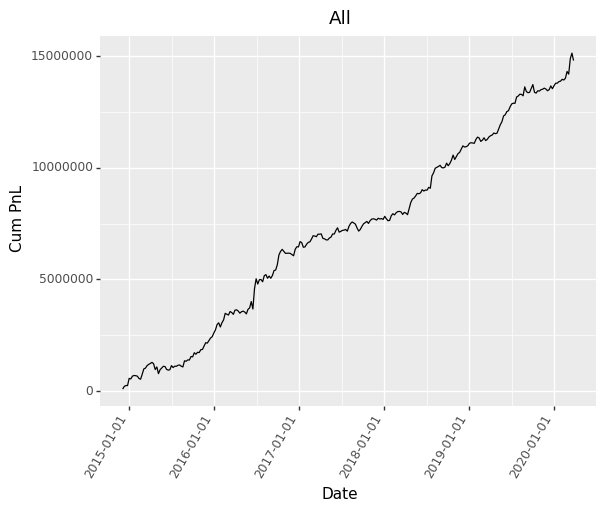

<ggplot: (8792666768727)>

In [261]:
g0= graph_cum_pnl(list(fx_all['Cum PnL']), list(fx_all.index), 'All')
g0

If the best possible trade was execute the graph would like above. 

In [262]:
stat_all= calculate_statistics_from_pnl(fx_all['Returns'])
stat_all = pd.Series(stat_all, index=columns)
stat= stat.append(stat_all, ignore_index=True)
stat.index= ['Thailand', 'Pakistan', 'Vietnam', 'Philipines', 'All']
stat

,Annualized Return,Mean Return,Volatility,Sharpe Ratio,Maximum Drawdown
Thailand,0.633033,0.003993,0.064559,-0.247943,-0.672602
Pakistan,0.407511,0.004868,0.083611,-0.180977,-0.777941
Vietnam,1.206803,0.005368,0.068143,-0.214732,-0.540161
Philipines,2.005332,0.006609,0.067286,-0.199018,-0.615395
All,416.435291,0.026621,0.071393,0.092743,-0.241740


<AxesSubplot: >

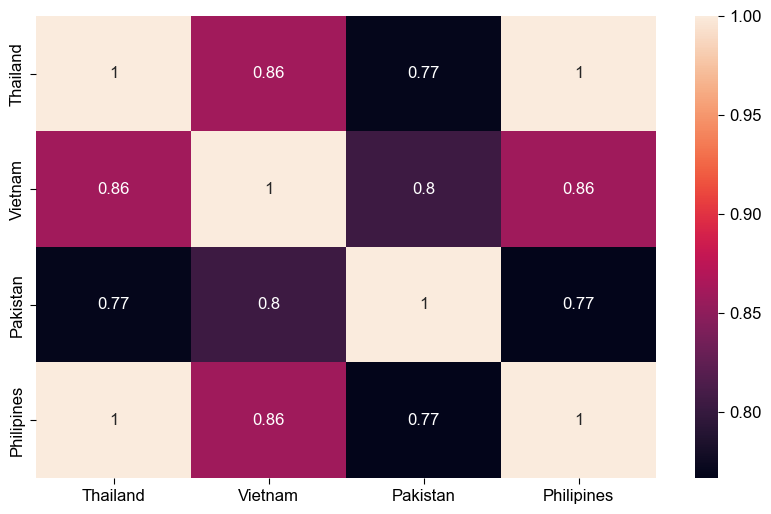

In [448]:
pnl_corr_df= pd.DataFrame()
pnl_corr_df['Thailand']= fx_data_t['PnL']
pnl_corr_df['Vietnam']= fx_data_v['PnL']
pnl_corr_df['Pakistan']= fx_data_p['PnL']
pnl_corr_df['Philipines']= fx_data_ph['PnL']
corr_matrix =pnl_corr_df.corr()
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True)

Correlation: Emerging market currencies are often highly correlated with each other, meaning that they tend to move in a similar direction. This can result in similar P&L outcomes for an FX trade strategy that involves multiple emerging market currencies. Here, we can see the returns of the different currencies are very highly correlated

In [405]:
def correlation_of_fx_carry_to_other_asset_classes(strategy_dataframe_ph):
    end_date_new= "2021-06-30"
    data_aapl= quandl.get_table('QUOTEMEDIA/PRICES', date = { 'gte': start_date, 'lte': end_date_new }, ticker='AAPL')
    data_aapl= data_aapl.set_index('date')
    data_aapl= data_aapl.interpolate(axis = 0, method = 'index').resample('W-WED').fillna(method="ffill")
    returns_aapl= data_aapl['adj_close'].pct_change()
    data_spx= quandl.get("CHRIS/CME_SP1", start_date= start_date, end_date= end_date_new)
    data_spx= data_spx.interpolate(axis = 0, method = 'index').resample('W-WED').fillna(method="ffill")
    returns_spx= data_spx['Settle'].pct_change()
    commodity_data = quandl.get("CHRIS/CME_CL1", start_date=start_date, end_date=end_date_new)
    commodity_data= commodity_data.interpolate(axis = 0, method = 'index').resample('W-WED').fillna(method="ffill")
    returns_commodity= commodity_data['Settle'].pct_change()
    fx_data_ph= FXCarry_Individual_Currencies(strategy_dataframe_ph[:"2021-07-01"])
    returns_ph= fx_data_ph['Returns']
    corr_df= pd.DataFrame()
    corr_df['AAPL']= returns_aapl
    corr_df['SPX']= returns_spx
    corr_df['CL1']= returns_commodity
    corr_df['FX-PH']= returns_ph
    corr_matrix =corr_df.corr()
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(corr_matrix, annot=True)
    return commodity_data, returns_aapl, returns_spx, returns_commodity, returns_ph

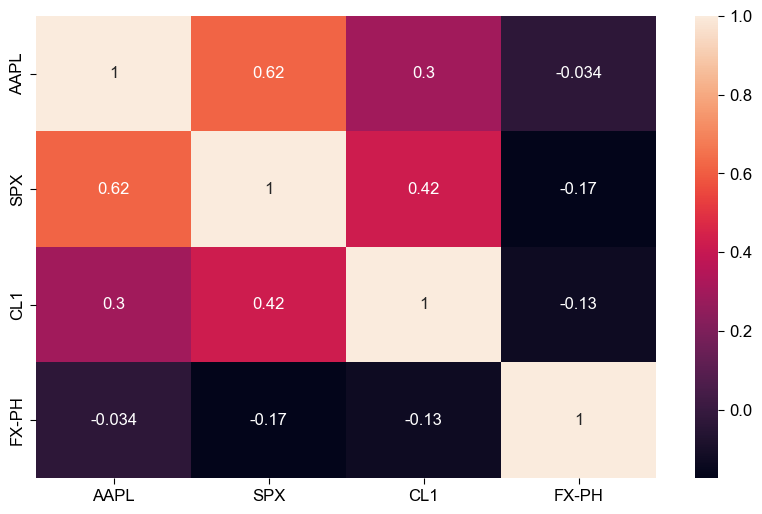

In [406]:
commodity_data, returns_aapl, returns_spx, returns_commodity, returns_ph= correlation_of_fx_carry_to_other_asset_classes(strategy_dataframe_ph)

(Here, we use the FX-Carry for Philipines because it gave the best results)

### It is important to look at the correlations of FX carry trade with other asset classes for several reasons:
1. Diversification: By understanding the correlations between FX carry trade and other asset classes, investors can assess the potential diversification benefits of adding FX carry trade to their portfolio. A low correlation between FX carry trade and other assets can reduce overall portfolio risk and increase portfolio stability.
2. Risk Management: By considering the correlations between FX carry trade and other assets, investors can identify potential risks and reduce the impact of market events on their portfolios. For example, if FX carry trade has a high correlation with a particular asset class that is experiencing a downturn, the investor may want to reduce exposure to that asset class or hedge against potential losses.
3. Performance evaluation: Correlation analysis can help investors to understand the performance of FX carry trade relative to other asset classes. For example, if FX carry trade has a high correlation with a particular asset class that is performing well, the investor may want to consider increasing exposure to that asset class or using it as a benchmark for FX carry trade performance.


### The case above
Since there is much of a correlation of the FX carry for philipnes with any of the above asset classes it would great for diversification anf risk managment. 

Furthermore, according to the graph Comparisons of Cumulative Returns, we use that our trade's performance is pretty good.

Text(0.5, 1.0, 'Comparisons of Cumulative Returns')

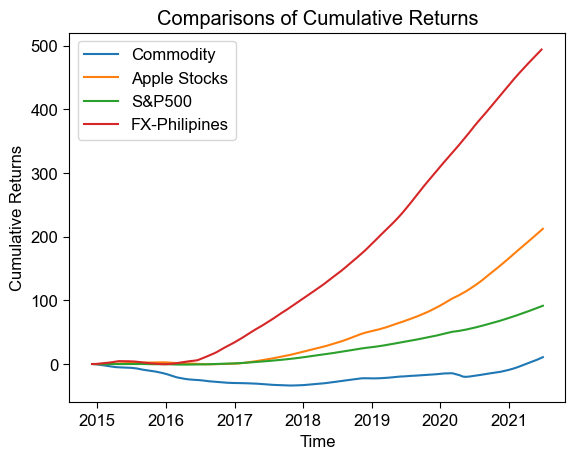

In [408]:
returns_commodity= pd.Series(returns_commodity).cumsum()
returns_aapl= pd.Series(returns_aapl).cumsum()
returns_spx= pd.Series(returns_spx).cumsum()
returns_ph= pd.Series(returns_ph).cumsum()
plt.plot(commodity_data.index, returns_commodity, label= "Commodity")
plt.plot(commodity_data.index, returns_aapl, label= "Apple Stocks")
plt.plot(commodity_data.index, returns_spx, label= "S&P500")
plt.plot(commodity_data.index[:343], returns_ph, label= "FX-Philipines")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.title('Comparisons of Cumulative Returns')

In [270]:
def calculate_rolling_tail_risks(returns, window_size):
    rolling_skewness = returns.rolling(window=window_size).skew().dropna()
    rolling_kurtosis = returns.rolling(window=window_size).kurt().dropna()
    return rolling_skewness, rolling_kurtosis

If your data has a long-term trend or seasonality, a larger window size may be better so that the rolling skew calculation is not as sensitive to short-term fluctuations in the data.
In general, a window size of between 10% and 30% of the total number of observations in the data is a good starting point, hence 15 was chosen as seen below

In [274]:
rolling_skewness_t, rolling_kurtosis_t= calculate_rolling_tail_risks(fx_data_t['Returns'], 15)
rolling_skewness_v, rolling_kurtosis_v= calculate_rolling_tail_risks(fx_data_v['Returns'], 15)
rolling_skewness_p, rolling_kurtosis_p= calculate_rolling_tail_risks(fx_data_p['Returns'], 15)
rolling_skewness_ph, rolling_kurtosis_ph= calculate_rolling_tail_risks(fx_data_ph['Returns'], 15)

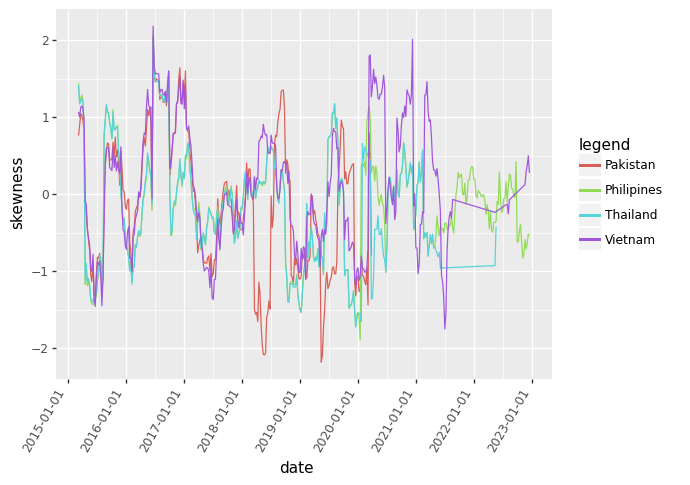

<ggplot: (8792595070814)>

In [289]:
def rolling_skewness_graph(sk1, sk2, sk3, sk4):
    
    data1= {'skewness': list(sk1), 'date': sk1.index, 'legend': ['Thailand']*len(sk1)}
    data2= {'skewness': list(sk2), 'date': sk2.index, 'legend': ['Vietnam']*len(sk2)}
    data3= {'skewness': list(sk3), 'date': sk3.index, 'legend': ['Pakistan']*len(sk3)}
    data4= {'skewness': list(sk4), 'date': sk4.index, 'legend': ['Philipines']*len(sk4)}
    
    df1 = pd.DataFrame(data1)
    df2 = pd.DataFrame(data2)
    df3 = pd.DataFrame(data3)
    df4 = pd.DataFrame(data4)
    
    df = pd.concat([df1, df2, df3, df4])
    plot= (ggplot(df)
    + aes(y='skewness', x='date', color='legend')
    + geom_line()
    + theme(axis_text_x=element_text(rotation=60, hjust=1))

    )
    return plot
g5= rolling_skewness_graph(rolling_skewness_t, rolling_skewness_v, rolling_skewness_p, rolling_skewness_ph)
g5

### What rolling skewness tells us?
Rolling skewness is a statistical measure that provides information about the distribution of returns over a specified time period. It measures the asymmetry of the returns distribution, and indicates whether the distribution is skewed to the right (positive skewness) or to the left (negative skewness).

A positive rolling skewness indicates that the returns distribution has a longer right tail, meaning that there are more large positive returns and fewer large negative returns. This can be an indication of a riskier investment, as it suggests that the investment is more likely to experience large losses in some periods.

On the other hand, a negative rolling skewness indicates that the returns distribution has a longer left tail, meaning that there are more large negative returns and fewer large positive returns. This can indicate a safer investment, as it suggests that the investment is less likely to experience large losses in some periods.



### What this graph tells us?
In the above graph the skewness flucntuates between -1 and 1 equally, hence it doesn't seem positively or negatively skewed which makes an analysis on this graph difficult

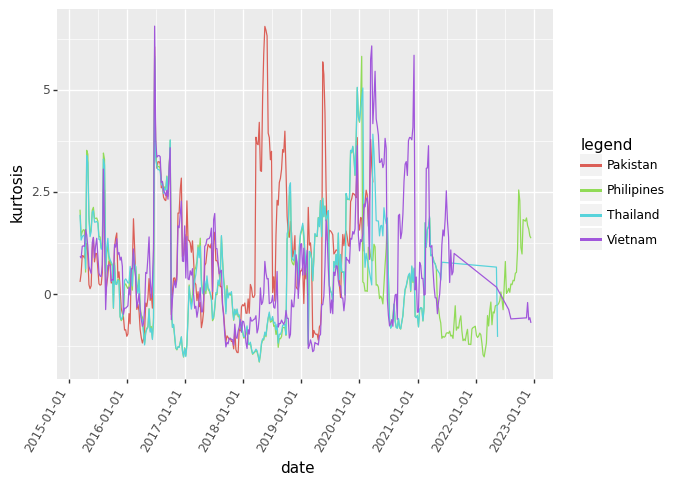

<ggplot: (8792680107846)>

In [291]:
def rolling_kurtosis_graph(sk1, sk2, sk3, sk4):
    
    data1= {'kurtosis': list(sk1), 'date': sk1.index, 'legend': ['Thailand']*len(sk1)}
    data2= {'kurtosis': list(sk2), 'date': sk2.index, 'legend': ['Vietnam']*len(sk2)}
    data3= {'kurtosis': list(sk3), 'date': sk3.index, 'legend': ['Pakistan']*len(sk3)}
    data4= {'kurtosis': list(sk4), 'date': sk4.index, 'legend': ['Philipines']*len(sk4)}
    
    df1 = pd.DataFrame(data1)
    df2 = pd.DataFrame(data2)
    df3 = pd.DataFrame(data3)
    df4 = pd.DataFrame(data4)
    
    df = pd.concat([df1, df2, df3, df4])
    plot= (ggplot(df)
    + aes(y='kurtosis', x='date', color='legend')
    + geom_line()
    + theme(axis_text_x=element_text(rotation=60, hjust=1))

    )
    return plot
g6= rolling_kurtosis_graph(rolling_kurtosis_t, rolling_kurtosis_v, rolling_kurtosis_p, rolling_kurtosis_ph)
g6

### What rolling skewness tells us?
Rolling kurtosis is a statistical measure that provides information about the shape of the distribution of returns over a specified time period. It measures the "peakedness" of the returns distribution, and indicates whether the distribution is more or less peaked than a normal distribution.

A positive rolling kurtosis indicates that the returns distribution is more peaked than a normal distribution, meaning that the returns are more concentrated around the mean and that there are more outliers (returns that are significantly higher or lower than the mean). This can be an indication of a riskier investment, as it suggests that the investment is more likely to experience large positive or negative returns in some periods.

A negative rolling kurtosis indicates that the returns distribution is less peaked than a normal distribution, meaning that the returns are less concentrated around the mean and that there are fewer outliers. This can indicate a safer investment, as it suggests that the investment is less likely to experience large positive or negative returns in some periods.

### What this graph tells us?
From above we see that it is more of a positive kurtosis. This tells us about this is a riskier investment as expected.

#### Evolution of the FX rates vs Interest Rate Differential – Analyze the trend in FX rates (GBP/Currency) and Interest Rate Differential b/w the lending rate (5 year yield curve for EM currencies) and borrowing rate (1 month OIS rate for UK)

In [426]:
ird_t= strategy_dataframe_t['SR-5Y']- gbr_data['0.08Y']
ird_v= strategy_dataframe_v['SR-5Y']- gbr_data['0.08Y']
ird_p= strategy_dataframe_p['SR-5Y']- gbr_data['0.08Y'][:279]
ird_ph= strategy_dataframe_ph['SR-5Y']- gbr_data['0.08Y']

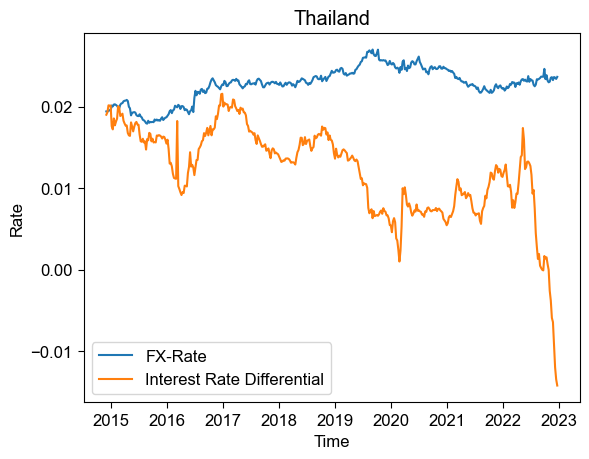

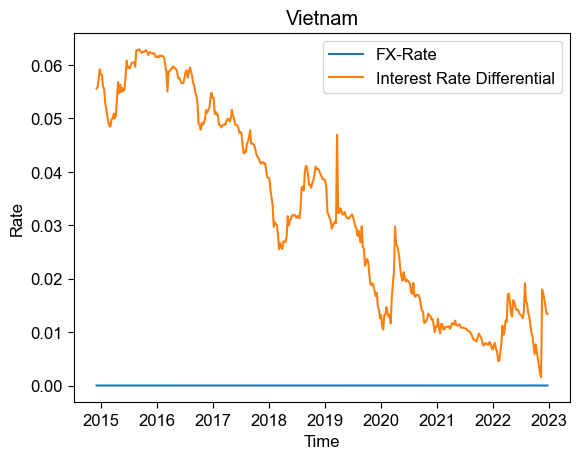

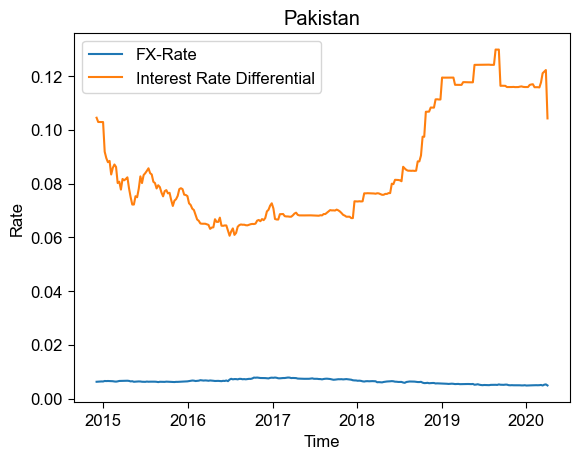

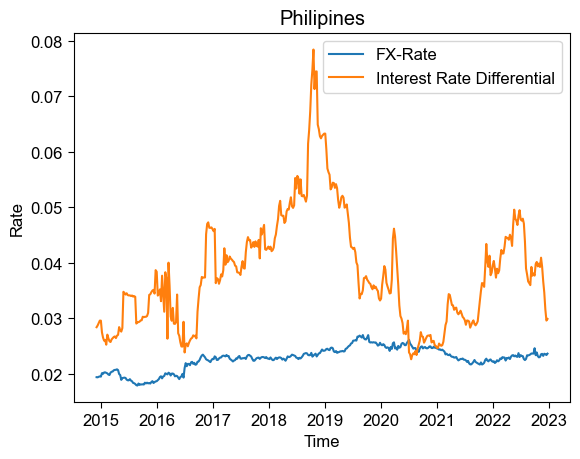

In [427]:
plt.plot(strategy_dataframe_t.index, strategy_dataframe_t['FX-Rate'], label='FX-Rate')
plt.plot(strategy_dataframe_t.index, ird_t, label='Interest Rate Differential')
plt.ylabel('Rate')
plt.xlabel('Time')
plt.title('Thailand')
plt.legend()
plt.show()
plt.plot(strategy_dataframe_v.index, strategy_dataframe_v['FX-Rate'], label='FX-Rate')
plt.plot(strategy_dataframe_v.index, ird_v, label='Interest Rate Differential')
plt.ylabel('Rate')
plt.xlabel('Time')
plt.title('Vietnam')
plt.legend()
plt.show()
plt.plot(strategy_dataframe_p.index, strategy_dataframe_p['FX-Rate'], label='FX-Rate')
plt.plot(strategy_dataframe_p.index, ird_p, label='Interest Rate Differential')
plt.ylabel('Rate')
plt.xlabel('Time')
plt.title('Pakistan')
plt.legend()
plt.show()
plt.plot(strategy_dataframe_ph.index, strategy_dataframe_ph['FX-Rate'], label='FX-Rate')
plt.plot(strategy_dataframe_ph.index, ird_ph, label='Interest Rate Differential')
plt.ylabel('Rate')
plt.xlabel('Time')
plt.title('Philipines')
plt.legend()
plt.show()


IRD AND FX rates: 
The evolution of FX (foreign exchange) rates and interest rate differentials is a complex and dynamic relationship that is influenced by many factors, including economic conditions, monetary policy, and political developments.

Interest rate differentials refer to the difference between the interest rates of two currencies. When a currency has a higher interest rate than another currency, it is considered to be more attractive for carry trade strategies, as investors can earn a higher return by borrowing in the lower-yielding currency and investing in the higher-yielding currency.

The FX rate, on the other hand, is the price of one currency in terms of another currency. The FX rate is influenced by a number of factors, including economic conditions, monetary policy, political developments, and the demand for the currency.

Analysis:
Thailand: FX rate remains almost the same, IRD shows a slight decrease

Vietname: IRD decreaing, even though the graph doesnt depict FX very well due to the small numbers, on further analysis we know its stays the same.

Pakistan: IRD: a dip and an increase. The graph doesnt depict FX very well due to the small numbers, on further analysis we know its stays the same.

Philipines: IRD: a peak in the middle and FX rate remains the same.

Trends: There doesnt seem a trend btween ird and fx as such hence they seem uncorrelated.


In [444]:
def return_decomposition(returns, ird_t, fx_rate):
    X= ird_t
    X = sm.add_constant(X)
    y= returns
    model = sm.OLS(y, X).fit()
    print("Interest Rate Differential")
    print(model.summary())
    intercept, beta = model.params
    print(intercept, beta)
    
    X= fx_rate
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    print("FX Rate")
    print(model.summary())
    intercept, beta = model.params
    print(intercept, beta)

In [445]:
x_data_ph= FXCarry_Individual_Currencies(strategy_dataframe_ph)
returns_ph= list(fx_data_ph['Returns'])
returns_ph.append(0)
return_decomposition(returns_ph, ird_t, strategy_dataframe_ph['FX-Rate'])

Interest Rate Differential
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4868
Date:                Sat, 11 Feb 2023   Prob (F-statistic):              0.486
Time:                        21:27:01   Log-Likelihood:                 540.06
No. Observations:                 421   AIC:                            -1076.
Df Residuals:                     419   BIC:                            -1068.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016    

### This linear regression is to decsribe the portion of return/risk driven by currency/interest rates.
An attempt to decompose the return drivers between FX rate change and Interest Rate Differential Change

IRD has a positive but small beta: A positive beta indicates that the asset's returns move in the same direction of the FX rate but also the fx rate has a smaller portion of the return driven by it.

FX rate has a negative beta but larger beta: A negative beta indicates that the asset's returns move in the opposite direction of the FX rate but also the fx rate has a higher portion of the return driven by it.


### Why does fx rate have a higher impact on fx carry returns than ird?
The impact of FX rates on FX carry returns can be greater than the impact of interest rate differentials (IRD) for several reasons:

Volatility: FX rates can be more volatile than IRD, meaning that they can change rapidly and unpredictably. This increased volatility can have a larger impact on FX carry returns, as the returns from the carry trade are directly linked to the FX rate.

Leverage: FX carry trades often involve the use of leverage, meaning that a small change in the FX rate can result in a large change in the returns of the trade. This amplifies the impact of FX rate changes on FX carry returns.


### Conclusion

1. The Strategy is Risky:
When things do downhill they go downhill in both ways that is neither will the IRD nor will the FX rate be in favour when something is going bad. It is like "picking pennies before a steam roller"

2. Advantage:
One of the key advantages of the FX carry trade strategy is that it can provide relatively stable returns, as long as the interest rate differentials between the two currencies remain relatively constant. 

We also saw above that it has diversification advantages because it is not correlated with the returns of other assets.

In conclusion, the FX carry trade strategy can be a useful investment tool for investors who are looking for a relatively stable source of returns and diversification benefits. However, it's important to carefully consider the risks involved and to consult with a financial professional before making any investment decisions.

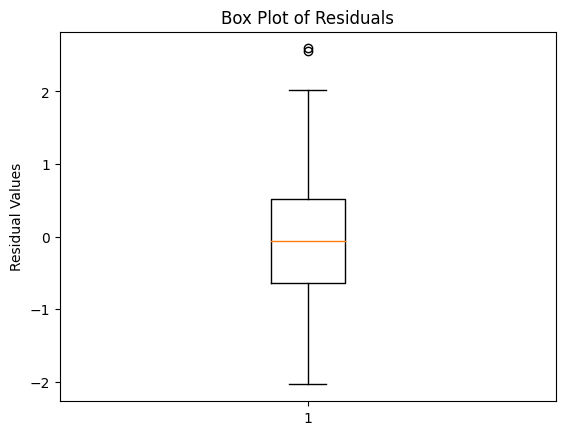

In [1]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Load data
x = np.random.normal(0, 1, 100)
y = 3 * x + np.random.normal(0, 1, 100)

# Fit linear regression model
X = sm.add_constant(x)
model = sm.OLS(y, X).fit()

# Calculate residuals
residuals = model.resid

# Create box plot of residuals
fig, ax = plt.subplots()
ax.boxplot(residuals)
ax.set_title('Box Plot of Residuals')
ax.set_ylabel('Residual Values')
plt.show()

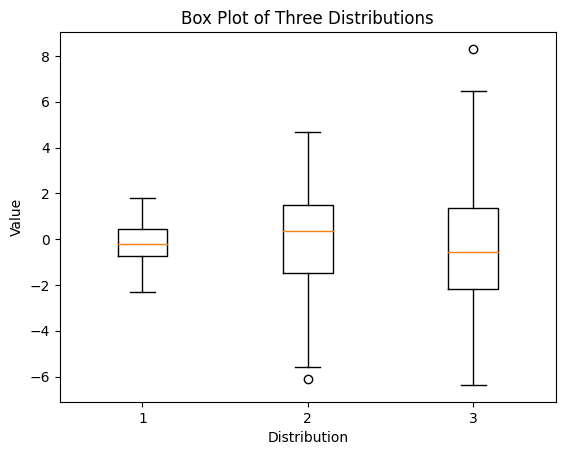

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
data = [np.random.normal(0, std, 100) for std in range(1, 4)]

# Create box plot
fig, ax = plt.subplots()
ax.boxplot(data)

# Set axis labels and title
ax.set_xlabel('Distribution')
ax.set_ylabel('Value')
ax.set_title('Box Plot of Three Distributions')

# Display the plot
plt.show()

In [10]:
data[0]

array([-0.99524354,  0.15837089, -0.01783327, -0.93336524, -0.25420138,
        0.42772091, -0.31495082,  0.40437659,  0.1413099 , -0.81687921,
       -0.80730987,  0.2683669 , -0.46343226,  0.39593805, -0.45860308,
       -1.64475145,  0.10759414,  0.60308786, -1.36197264,  1.02133919,
        1.54474003, -0.53234581,  0.96275984, -0.11429492,  0.91534145,
       -2.31078817, -0.70435025,  0.44181637,  0.77108093, -0.58095845,
       -0.40943626, -0.42374417, -0.01451623, -0.87119913, -1.63068307,
        0.3031202 , -0.79176952, -1.4483298 , -0.9240089 , -0.46228862,
       -2.29743706,  0.12142187,  1.54582567,  0.06485609, -1.59703057,
       -2.17629173, -0.47257786,  0.83896917,  1.78249172,  0.59034388,
       -1.14348334,  0.57363082,  0.02205854,  0.86568088,  0.81453491,
       -0.51497007, -0.58015682, -1.06885974, -0.25857919,  0.67215471,
        0.45551648, -0.20560645, -0.81892557,  0.06814838, -0.38891029,
        1.11646983, -0.52479174,  1.17753712,  1.38818101, -0.68

In [14]:
import pandas as pd
import seaborn as sns

# Create a sample DataFrame
df = pd.DataFrame({
                   'Value_1': [1, 2, 3, 4, 5, 6],
                   'Value_2': [2, 4, 6, 8, 10, 12]})

# Reshape the DataFrame using the melt() function
melted_df = pd.melt(df, id_vars=['Group'], value_vars=['Value_1', 'Value_2'],
                    var_name='Value', value_name='Score')

# Create a violin plot
sns.violinplot(x='Group', y='Score', hue='Value', data=melted_df)

# Display the plot
plt.show()

KeyError: "The following 'id_vars' are not present in the DataFrame: ['Group']"